In [1]:
import matplotlib.pylab as plt
import numpy as np
import MDAnalysis as mdanal
%matplotlib inline

In [2]:
def getCoordinates(pdbFileName, trjFileName):
    u = mdanal.Universe(pdbFileName, trjFileName, permissive=False);
    frames = [];
    Ca = u.select_atoms('name CA');
    for ts in u.trajectory:
        frames.append(Ca.positions.T);
    return np.array(frames);

In [3]:
import os
indir = '/Volumes/LaCie/DESRES-Trajectory-bpti-protein/bpti-protein/'
topfile = '/Users/fxp/BPTI-Analysis/bpti-protein.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('.dcd'):
        traj_list.append(os.path.join(indir,filename))

In [4]:
plt.style.use('ggplot')

In [5]:
coords = []
for trj in traj_list:
    coords.append(getCoordinates(topfile, trj))
coords = np.vstack(coords)

In [6]:
coords = coords[::10, :, :];

In [7]:
from anca import IterativeMeansAlign
iterAlign = IterativeMeansAlign.IterativeMeansAlign();
[itr, avgCoordsAll, eRMSDAll, newCoordsAll] = iterAlign.iterativeMeans(coords, 0.001, 5);

No handlers could be found for logger "main.IterativeMeansAlign"


In [8]:
coordsAll = np.reshape(newCoordsAll, (len(newCoordsAll), 3*58)).T; 
avgCoordsAll = np.mean(coordsAll, 1); #print avgCoords;
tmpAll = np.reshape(np.tile(avgCoordsAll, 412497), (412497,3*58)).T; 
caDevsMDall = coordsAll - tmpAll;
print caDevsMDall.shape;

(174, 412497)


In [9]:
from anca import SD2
(Y, D, B, B1) = SD2.SD2(coordsAll.T, m=174);

2nd order Spatial Decorrelation -> Looking for 174 sources
2nd order Spatial Decorrelation -> Removing the mean value
2nd order Spatial Decorrelation -> Whitening the data


In [10]:
from anca import TD2
(Z, D2, Bstd2, B2) = TD2.TD2(Y, m=174, B1=B1, lag=1000)

2nd order Temporal Decorrelation -> Removing the mean value
2nd order Temporal Decorrelation -> Whitening the data


In [11]:
from anca import TD4
Btd4 = TD4.TD4(Z[0:10,:], m=10, B2=B2[0:10,:], lag=1000)

4th order Temporal Decorrelation -> Estimating cumulant matrices


/Users/fxp/anaconda2/lib/python2.7/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.4, you have 2.3.2.
  .format(latest=latest, current=current), category=UserWarning)


TD4 -> Contrast optimization by joint diagonalization
TD4 -> Sweep #  0 completed in 45 rotations
TD4 -> Sweep #  1 completed in 45 rotations
TD4 -> Sweep #  2 completed in 45 rotations
TD4 -> Sweep #  3 completed in 45 rotations
TD4 -> Sweep #  4 completed in 45 rotations
TD4 -> Sweep #  5 completed in 44 rotations
TD4 -> Sweep #  6 completed in 39 rotations
TD4 -> Sweep #  7 completed in 28 rotations
TD4 -> Sweep #  8 completed in 14 rotations
TD4 -> Sweep #  9 completed in 2 rotations
TD4 -> Sweep # 10 completed in 0 rotations
TD4 -> Total of 352 Givens rotations
TD4 -> Sorting the components
TD4 -> Fixing the signs


In [12]:
ZPrj4 = Btd4.dot(caDevsMDall)
ZPrj4 = np.asarray(ZPrj4);
print ZPrj4.shape

(10, 412497)


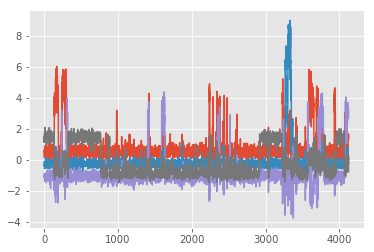

In [13]:
plt.plot(ZPrj4[0, ::100]);
plt.plot(ZPrj4[1, ::100]);
plt.plot(ZPrj4[2, ::100]);
plt.plot(ZPrj4[3, ::100]);
plt.show()

[ 11.17311575  52.31644253  13.51103071   1.97574446  26.34076028
  72.1388425   30.81855293  47.18237577   6.22428187  11.26741238]
[ 30.24864194   1.9129751    6.82629706  21.90914651   8.79593027
  12.76683225  31.36094006  26.61943444   9.50712157   5.93712442]
(412497, 10)
(412497, 10)


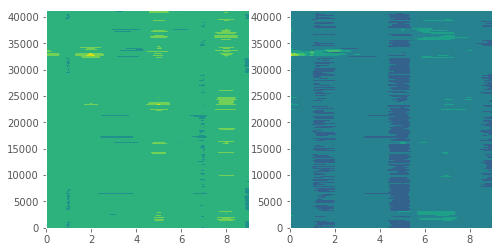

In [14]:
import scipy.stats
kTD4 = scipy.stats.kurtosis(ZPrj4, axis=1, fisher=False); print kTD4; 
kTD2 = scipy.stats.kurtosis(Z[0:10,:], axis=1, fisher=False); print kTD2;
iTD4 = np.argsort(-kTD4); 
iTD2 = np.argsort(-kTD2);

# Sort all the TD2 and TD4 based on kurtosis
YTD2 = Z.T[:,0:10]; print YTD2.shape;
YTD4 = ZPrj4.T; print YTD4.shape;

YTD2 = YTD2[:, iTD2]; 
YTD4 = YTD4[:, iTD4];

fig, ax = plt.subplots(1, 2, figsize=(8,4));
ax[0].contourf(YTD2[::10,:]);
ax[1].contourf(YTD4[::10,:]);
plt.show();

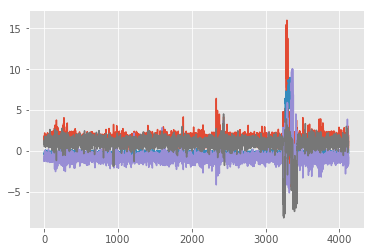

In [15]:
plt.plot(YTD4[::100,0]);
plt.plot(YTD4[::100,1]);
plt.plot(YTD4[::100,2]);
plt.plot(YTD4[::100,3]);
plt.show()

In [ ]:
np.save('caDevsMDall.npy', caDevsMDall);
np.save('newCoords.npy', newCoordsAll);

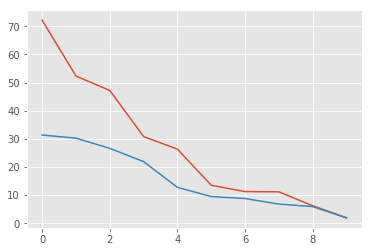

In [16]:
plt.plot(kTD4[iTD4]); 
plt.plot(kTD2[iTD2]);
plt.show();

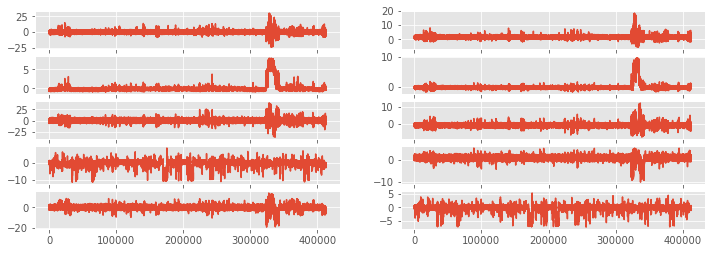

In [17]:
fig, ax = plt.subplots(5, 2, figsize=(12,4));
ax[0,0].plot(YTD2[:,0]); ax[0,0].set_xticklabels([]); 
ax[0,1].plot(YTD4[:,0]); ax[0,1].set_xticklabels([]);
ax[1,0].plot(YTD2[:,1]); ax[1,0].set_xticklabels([]);
ax[1,1].plot(YTD4[:,1]); ax[1,1].set_xticklabels([]);
ax[2,0].plot(YTD2[:,2]); ax[2,0].set_xticklabels([]);
ax[2,1].plot(YTD4[:,2]); ax[2,1].set_xticklabels([]);
ax[3,0].plot(YTD2[:,3]); ax[3,0].set_xticklabels([]);
ax[3,1].plot(YTD4[:,3]); ax[3,1].set_xticklabels([]);
ax[4,0].plot(YTD2[:,4]); 
ax[4,1].plot(YTD4[:,4]); 

In [18]:
np.save('caDevsMDall.npy', caDevsMDall);
np.save('newCoords.npy', newCoordsAll);